<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/PyTorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 39.52 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
from going_modular.going_modular import data_setup
from torchvision import transforms

IMAGE_SIZE = 224

mannual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor()])

In [7]:
BATCH_SIZE = 32

# Create DataLoaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=mannual_transforms,
                                                                               batch_size=BATCH_SIZE)

train_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a5db3f4f4f0>,
 ['pizza', 'steak', 'sushi'])

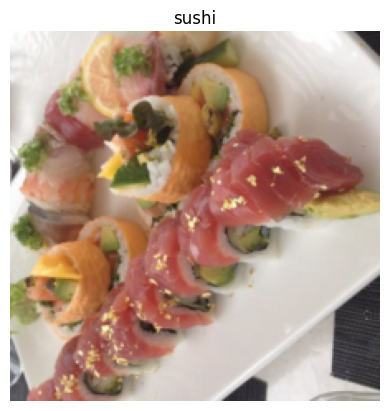

In [8]:
# Visualize a single image
import matplotlib.pyplot as plt

image_batch, image_label = next(iter(train_dataloader))

img, label = image_batch[0], image_label[0]

plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

# Replicating VIT

In [9]:
#Create example balues
height = 224
width = 224
color_channels = 3
patch_size = 16

#Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [10]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input {embedding_layer_input_shape}')
print(f'Output {embedding_layer_output_shape}')

Input (224, 224, 3)
Output (196, 768)


# Turning a picture into pathes

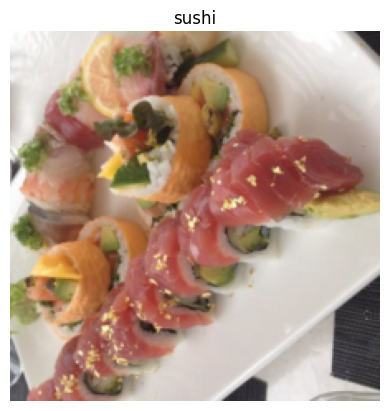

In [11]:
plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

In [12]:
img.shape

torch.Size([3, 224, 224])

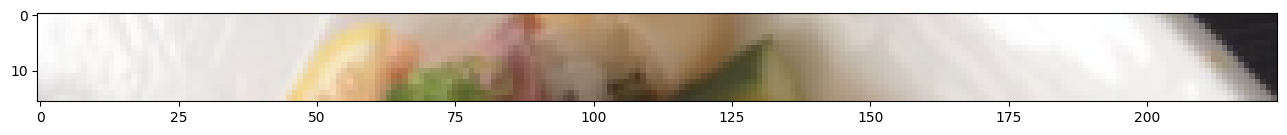

In [13]:
#get the top row
permuted_image = img.permute(2, 1, 0)

path_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(permuted_image[:patch_size, :,  :])

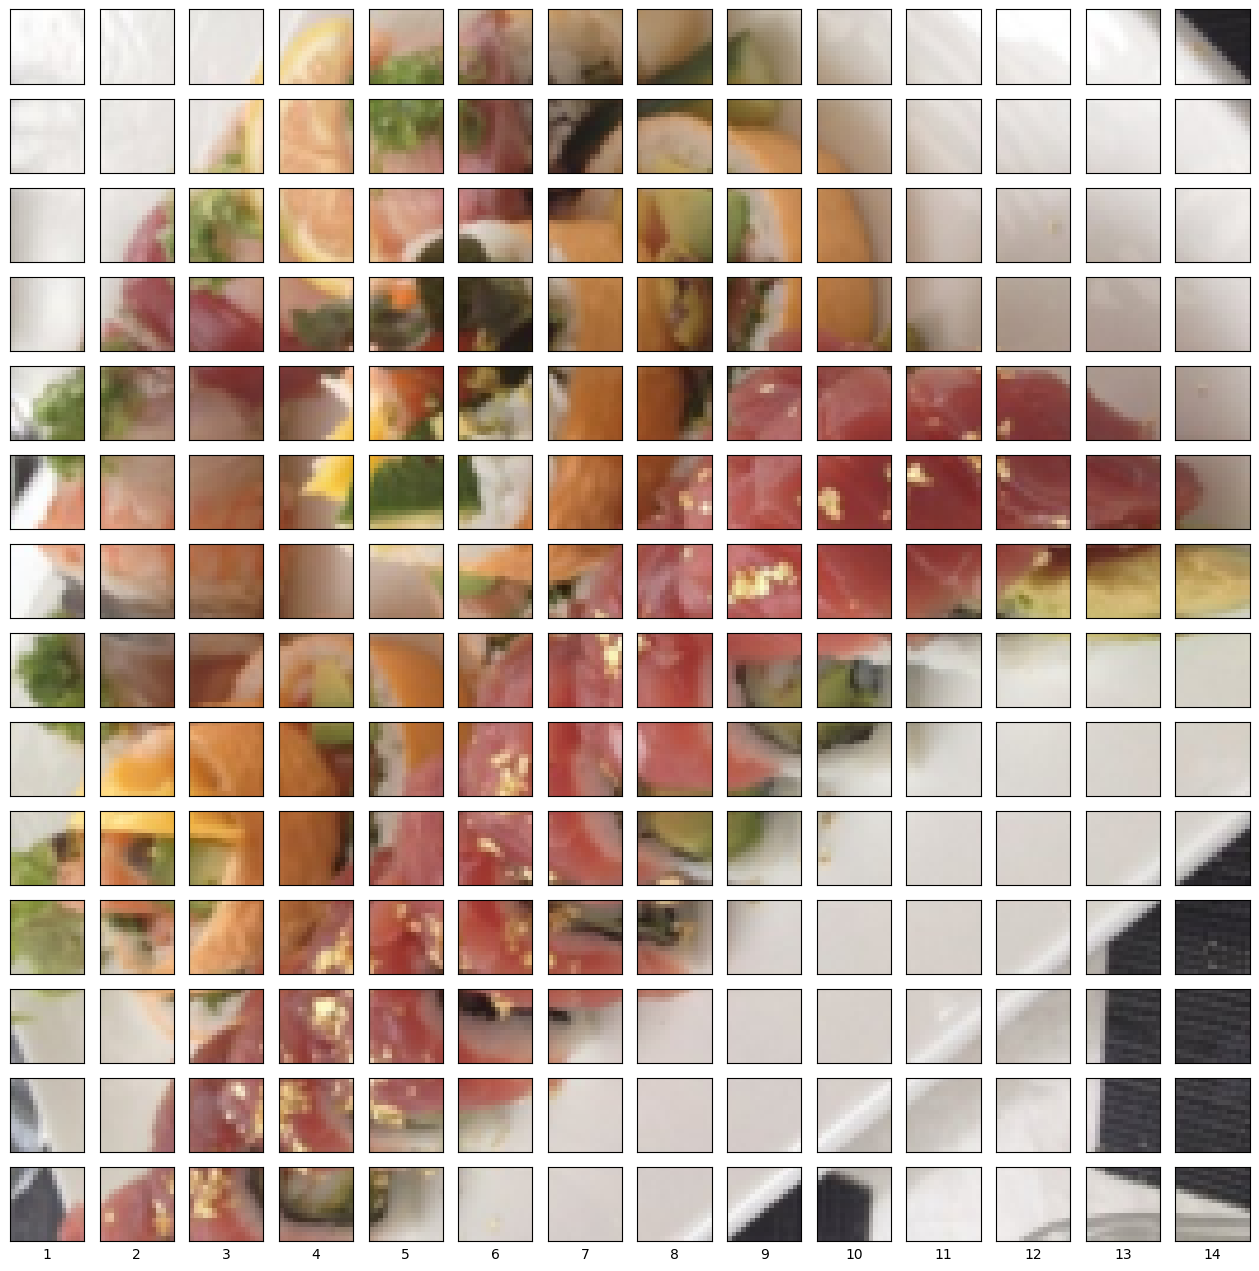

In [14]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, 'Image size must be devisible by patch size'

#create a series of subplots

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))

# itter through number of patches
# x_label_num = 0

for j, rowpatch in enumerate(range(0, img_size, patch_size)):
  for i, colpatch in enumerate(range(0, img_size, patch_size)):
    #x_label_num += 1
    axs[j][i].imshow(permuted_image[rowpatch:rowpatch+patch_size, colpatch:colpatch+patch_size, :]);
    axs[j][i].set_xlabel(i+1)
    axs[j][i].set_xticks([])
    axs[j][i].set_yticks([])
    axs[j, i].label_outer()

# Creating image patches and turning them into patch embeddings

In [15]:
#Create conv2d layer to turn image into patches of learnable feature maps(embeddings)
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3, #for color images
                   out_channels = 768, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

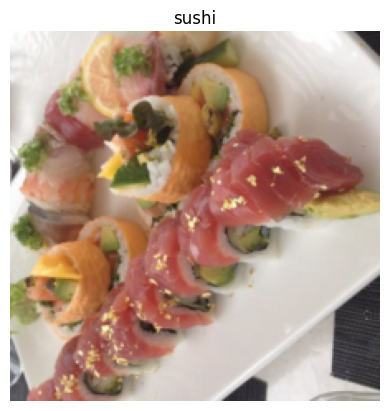

In [16]:
plt.imshow(img.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis('off');

In [17]:
image_out_of_conv = conv2d(img.unsqueeze(0)) #adding batch dimension
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [18]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-1.0233, -0.9879, -0.9308, -0.9225, -0.8388, -0.8270, -0.8884,
           -0.5963, -0.8442, -0.7802, -0.6246, -0.7498, -0.8893, -0.5546],
          [-1.0095, -0.9830, -0.8253, -0.5399, -0.4976, -0.6852, -0.6087,
           -0.4595, -0.7769, -0.8002, -0.8009, -0.9338, -0.7884, -0.6888],
          [-0.9586, -0.9997, -0.6632, -0.5436, -0.4819, -0.5477, -0.5240,
           -0.5874, -0.6495, -0.6011, -0.7571, -0.5341, -0.5513, -0.5892],
          [-0.8729, -0.8630, -0.8222, -0.5718, -0.5776, -0.6922, -0.5623,
           -0.6417, -0.4174, -0.4100, -0.5632, -0.6015, -0.4778, -0.5743],
          [-0.6582, -0.6069, -0.6631, -0.3868, -0.5782, -0.4976, -0.7651,
           -0.6425, -0.6490, -0.6009, -0.5589, -0.5205, -0.5934, -0.6854],
          [-0.5521, -0.4172, -0.5464, -0.2509, -0.6241, -0.8029, -0.6378,
           -0.5048, -0.5639, -0.5352, -0.6055, -0.5805, -0.7709, -0.9128],
          [-0.5318, -0.3732, -0.6686, -0.5758, -0.6378, -0.5839, -0.4821,
           -0.6075, -0.5440, -0.

In [19]:
# flatten
flatten = nn.Flatten(start_dim=2)
img_flat = flatten(image_out_of_conv)
print(img_flat.shape)

torch.Size([1, 768, 196])


In [20]:
#Rearrange output of flattened layer
img_flat = img_flat.permute(0, 2, 1)
img_flat.shape

torch.Size([1, 196, 768])

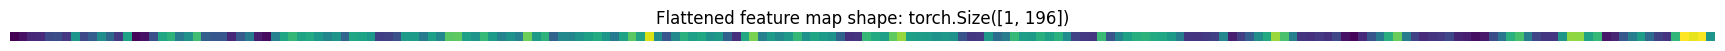

In [21]:
# Get a single flatten feature map
single_flattened_feature_map = img_flat[:, :, 0]

#Plot the flattened feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis('off');

In [22]:
first_block = nn.Sequential(
    nn.Conv2d(in_channels=3, #for color images
                   out_channels = 768, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0),
    nn.Flatten(start_dim=2)
)

In [23]:
first_block

Sequential(
  (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (1): Flatten(start_dim=2, end_dim=-1)
)

In [24]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int=3,
               patch_size: int=16,
               embedding_dim: int=768):
    super().__init__()
    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels=in_channels, #for color images
                   out_channels = embedding_dim, #D size from Table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

    self.flatten = nn.Flatten(start_dim=2)

  def forward(self, x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flatten = self.flatten(x_patched)

    return x_flatten.permute(0, 2, 1)



In [25]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

patch_embedded_image = patchify(img.unsqueeze(0))
print(patch_embedded_image.shape)

torch.Size([1, 196, 768])


#Creating the ckass token embedding

In [26]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [27]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [28]:
#add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # patch dimention

patch_embedded_image_with_class_embedding.shape, patch_embedded_image_with_class_embedding

(torch.Size([1, 197, 768]),
 tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.9701,  0.2381, -0.2768,  ...,  0.7679, -0.4387,  0.3723],
          [-0.9927,  0.2351, -0.2761,  ...,  0.7276, -0.4186,  0.3422],
          ...,
          [-0.2423,  0.0661, -0.0640,  ...,  0.1956, -0.1203,  0.0911],
          [-0.2452,  0.0590, -0.1054,  ...,  0.1806, -0.0912,  0.1049],
          [-0.6780,  0.2772, -0.0976,  ...,  0.5551, -0.1952, -0.0280]]],
        grad_fn=<CatBackward0>))

#Creating the position embedding

In [29]:
#Calculate number of patches
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)
position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [30]:
#add the position embeding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.0299, 1.2381, 0.7232,  ..., 1.7679, 0.5613, 1.3723],
          [0.0073, 1.2351, 0.7239,  ..., 1.7276, 0.5814, 1.3422],
          ...,
          [0.7577, 1.0661, 0.9360,  ..., 1.1956, 0.8797, 1.0911],
          [0.7548, 1.0590, 0.8946,  ..., 1.1806, 0.9088, 1.1049],
          [0.3220, 1.2772, 0.9024,  ..., 1.5551, 0.8048, 0.9720]]],
        grad_fn=<AddBackward0>))

#Putting all together

In [31]:
set_seeds()

patch_size = 16

print(f'Image tensor shape {img.shape}')

height, width = img.shape[1], img.shape[-1]

#image tensor and add a batch dimention
x = img.unsqueeze(0)
print(f'Input Image shape {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f'class token shape {class_token.shape}')
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedding),
                                                      dim=1)
print(f'patch_embedded_image_with_class_embedding shape {patch_embedded_image_with_class_embedding.shape}')
number_of_patches = int((height * width) / patch_size**2)

position_embedding = nn.Parameter(torch.rand(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(f'patch_and_position_embedding shape {patch_and_position_embedding.shape}')
# patch_and_position_embedding, patch_and_position_embedding.shape

Image tensor shape torch.Size([3, 224, 224])
Input Image shape torch.Size([1, 3, 224, 224])
Patch embedding shape torch.Size([1, 196, 768])
class token shape torch.Size([1, 1, 768])
patch_embedded_image_with_class_embedding shape torch.Size([1, 197, 768])
patch_and_position_embedding shape torch.Size([1, 197, 768])


#Equation 2 MSA Block



In [32]:
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
    super().__init__()

    #Create norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # output is (batch, seq, features) => (batch, number_of_patches, embedding_dimention)


  def forward(self, x):
    x = self.layer_norm(x)
    attn_output,_ = self.multihead_attn(query=x,
                                        key=x,
                                        value=x,
                                        need_weights=False)

    return attn_output

In [33]:
#Create an instance

# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# Equation 3 MLP \Block

In [34]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [35]:
mlp_block = MLPBlock()

patched_iamge_trough_mlp_block = mlp_block(patched_image_through_msa_block)

patched_iamge_trough_mlp_block.shape

torch.Size([1, 197, 768])

#Creating Transformer Encoder

In [36]:
class TransformerEncoderBlock(nn.Module):
  """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
    super().__init__()
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)


  def forward(self, x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x
    return x

In [37]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#Creating a Transformer Encoder with PyTorch's Transformer layers

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [39]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

#Putting it all together

In [40]:
#  Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
  """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
    super().__init__()
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size * img_size) // patch_size**2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                       num_heads=num_heads,
                                                                       mlp_size=mlp_size,
                                                                       mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    class_token = self.class_embedding.expand(batch_size, -1, -1 ) # -1 means to infer the dimensions

    x = self.patch_embedding(x)

    x = torch.cat((class_token, x), dim=1)

    x = self.position_embedding + x

    x = self.embedding_dropout(x)

    x = self.transformer_encoder(x)

    x = self.classifier(x[:, 0])

    return x

In [41]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=-1)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
 

In [42]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)


tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [43]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

#Training the ViT model

In [44]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

In [54]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3573 | train_acc: 0.3477 | test_loss: 2.0349 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.4706 | train_acc: 0.2695 | test_loss: 2.0035 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4786 | train_acc: 0.3008 | test_loss: 1.4158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2046 | train_acc: 0.2812 | test_loss: 1.4409 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2076 | train_acc: 0.2930 | test_loss: 1.0866 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1644 | train_acc: 0.3086 | test_loss: 1.0937 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1123 | train_acc: 0.3984 | test_loss: 1.1553 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1437 | train_acc: 0.2812 | test_loss: 1.1280 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1451 | train_acc: 0.3125 | test_loss: 1.1047 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1404 | train_acc: 0.2969 | test_loss: 1.1346 | test_acc: 0.2604


# Plotting loss curve

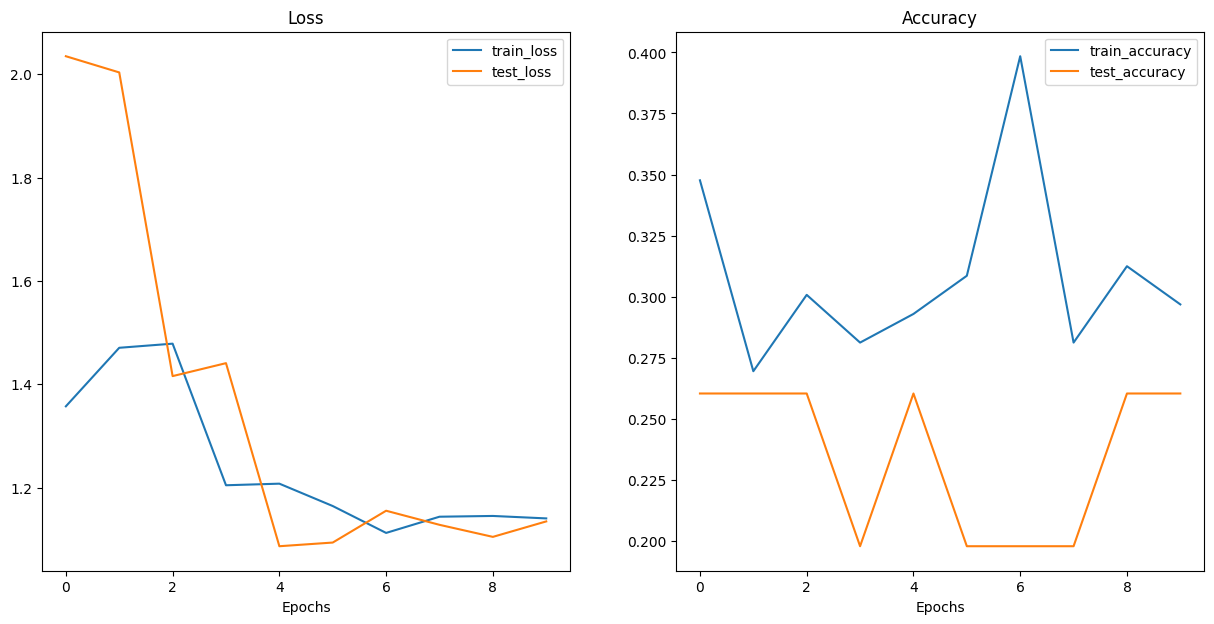

In [55]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Using pretrained model

In [65]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [66]:
#freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [67]:
from torchinfo import summary


summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [68]:
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [70]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32)

In [73]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)

set_seeds()

results_pretrained = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


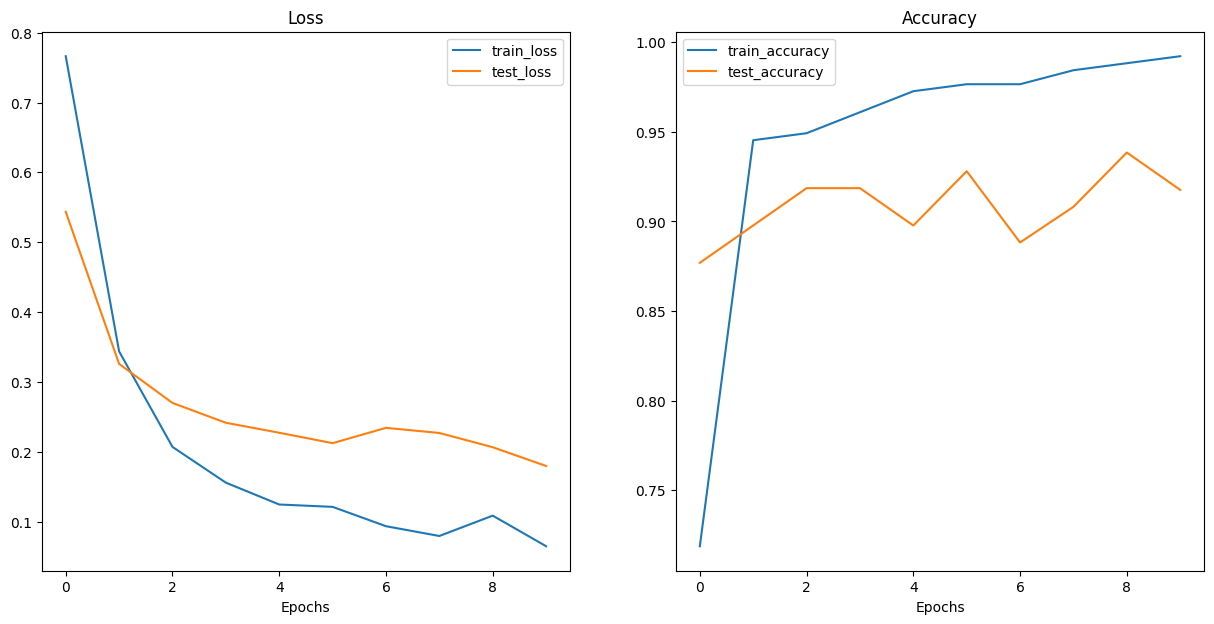

In [74]:
from helper_functions import plot_loss_curves

plot_loss_curves(results_pretrained)

# Save the *Model*

In [75]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [76]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


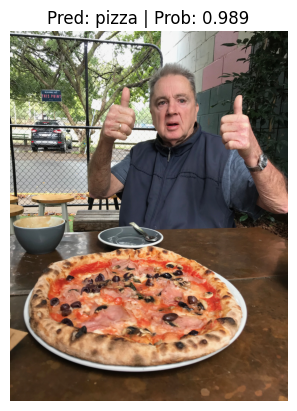

In [77]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)